# For the clustering project, we are using DBSCAN to specifically analyze and remove outliers, and then applying KMeans to cluster the remaining data for enhanced accuracy in grouping. The results are visualized using PCA.

## 1. Data Prep

In [285]:
# a. Read in the data file wholesale_clients.csv
import pandas as pd

df= pd.read_csv('../Data/wholesale_clients.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [187]:
# b. Remove the Channel (restaurant, hotel, etc.) and Region columns since they are not fields we want to model on
data = df.iloc[:, 2:]
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [189]:
# c. Note the number of rows and columns
data.shape

(440, 6)

In [191]:
# d. Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


In [192]:
# e. Double check that all the column means are 0 and standard deviations are 1
data_scaled.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,-3.431598e-17,0.000000,-4.037175e-17,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-9.496831e-01,-0.778795,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-7.023339e-01,-0.578306,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-2.767602e-01,-0.294258,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,3.905226e-01,0.189092,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,7.927738e+00,9.183650,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


## 2. DBSCAN model

In [196]:
# a. Copy over the tune_dbscan function from the demo code
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through (choose from 2 to 5)
    eps_values = np.arange(.1, 5, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score (excluding noise points)
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters",
                                                    "Number of Noise Points", "Silhouette Score"])
    return dbscan_results

In [198]:
# b. Apply the dbscan function on the scaled data
dbscan_results = tune_dbscan(data_scaled)
dbscan_results.head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,0.1,2,8,423,-0.393
1,0.1,3,1,437,NaN
2,0.1,4,0,440,NaN
3,0.1,5,0,440,NaN
4,0.1,6,0,440,NaN


In [199]:
# c. Sort the data by highest silhouette score
dbscan_results.sort_values(by='Silhouette Score', ascending=False)

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
272,3.5,2,2,8,0.740284
264,3.4,2,2,8,0.740284
256,3.3,2,2,8,0.740284
248,3.2,2,2,8,0.740284
224,2.9,2,2,10,0.582247
...,...,...,...,...,...
387,4.9,5,1,5,NaN
388,4.9,6,1,5,NaN
389,4.9,7,1,5,NaN
390,4.9,8,1,6,NaN


In [200]:
# view one result for each silhouette score value
(dbscan_results.sort_values('Silhouette Score', ascending=False)
               .groupby('Silhouette Score')
               .head(1)).head(10)

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
272,3.5,2,2,8,0.740284
224,2.9,2,2,10,0.582247
136,1.8,2,2,13,0.581583
122,1.6,4,2,24,0.578543
232,3.0,2,3,8,0.577890
96,1.3,2,3,25,0.424572
105,1.4,3,3,23,0.423547
113,1.5,3,3,21,0.421271
89,1.2,3,2,32,0.419507
81,1.1,3,2,40,0.417466


From the table, we can choose the number of clusters and anomalies for our cluster. We can choose base on highestn silhouette score

In [202]:
# Choose silhouette score with Eps =3.5, Min samples = 2
dbscan2 = DBSCAN(eps=3.5, min_samples=2)
dbscan2.fit(data_scaled)

DBSCAN(eps=3.5, min_samples=2)

In [203]:
# number of data points in each cluster
from collections import Counter
Counter(dbscan2.labels_)

Counter({0: 430, -1: 8, 1: 2})

From this we can filter the outlier and cluster again to enhance the efficient for custormer segmentation. Besides, our Marketing team can analyze the outlier too.

In [205]:
df['DBSCAN_cluster']= dbscan2.labels_
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,0


In [206]:
# We filter outlier, so manager can see and make a cluster again to enhance clustering accuracy
df[df['DBSCAN_cluster']!=0]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster
23,2,3,26373,36423,22019,5154,4337,16523,-1
47,2,3,44466,54259,55571,7782,24171,6465,1
61,2,3,35942,38369,59598,3254,26701,2017,1
85,2,3,16117,46197,92780,1026,40827,2944,-1
86,2,3,22925,73498,32114,987,20070,903,-1
93,1,3,11314,3090,2062,35009,71,2698,-1
181,1,3,112151,29627,18148,16745,4948,8550,-1
183,1,3,36847,43950,20170,36534,239,47943,-1
325,1,2,32717,16784,13626,60869,1272,5609,-1
333,2,2,8565,4980,67298,131,38102,1215,-1


In [207]:
# Now we can continue clustering with effective data
data_cluster = df[df['DBSCAN_cluster']==0]
data_cluster.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,0


In [208]:
# Remove the Channel (restaurant, hotel, etc.) and Region columns since they are not fields we want to model on
data = data_cluster.iloc[:,2:]
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,0


In [209]:
# drop DBSCAN_cluster also
data.drop(columns='DBSCAN_cluster',inplace=True)

In [210]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [211]:
#  Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.103978,0.896020,0.043570,-0.777226,0.026766,-0.001121
1,-0.383280,0.926465,0.319942,-0.303520,0.193609,0.285739
2,-0.444404,0.728374,0.060508,-0.106755,0.253716,4.259858
3,0.155726,-0.776483,-0.416361,1.116985,-0.557319,0.293598
4,0.967533,0.056605,-0.006416,0.355323,-0.215008,2.518397


## 3. K-means clustering

In [213]:
# import kmeans and write a loop to fit models with 2 to 15 clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# create an empty list to hold many inertia and silhouette values
inertia_values = []
silhouette_scores = []

# create 2 - 15 clusters, and add the intertia scores and silhouette scores to the lists
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # changed from auto to 10
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_, metric='euclidean', sample_size=None))

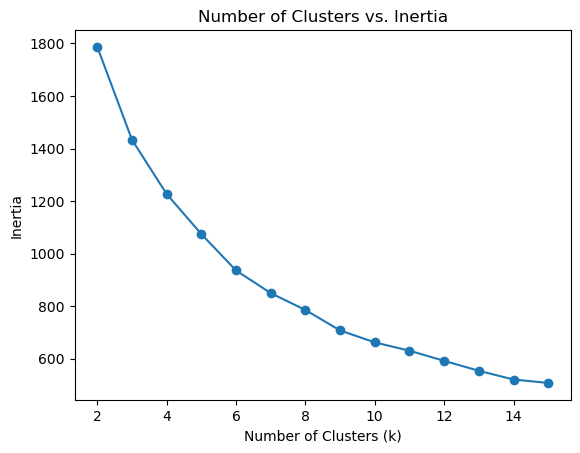

In [214]:
# plot the inertia values
import matplotlib.pyplot as plt

# turn the list into a series for plotting
inertia_series = pd.Series(inertia_values, index=range(2, 16))

# plot the data
inertia_series.plot(marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

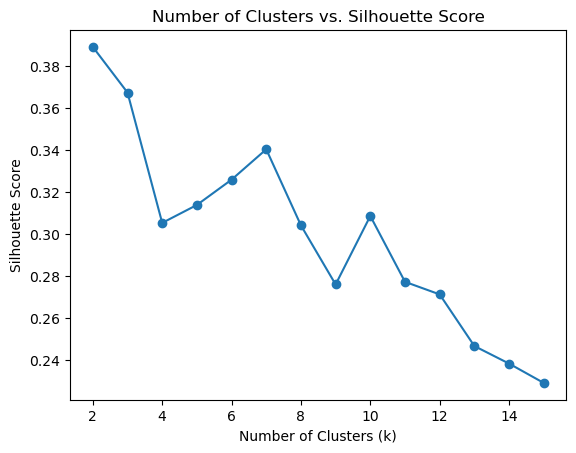

In [217]:
# plot the silhouette scores
# turn the list into a series for plotting
silhouette_series = pd.Series(silhouette_scores, index=range(2, 16))

# plot the data
silhouette_series.plot(marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Number of Clusters vs. Silhouette Score");

We can choose k = 4 for clustering

In [229]:
kmeans4 = KMeans(n_clusters=4, n_init='auto', random_state=42)
kmeans4.fit(data_scaled)

KMeans(n_clusters=4, random_state=42)

In [230]:
# d. Find the number of clients in each cluster
from collections import Counter

Counter(kmeans4.labels_)

Counter({0: 266, 1: 79, 3: 68, 2: 17})

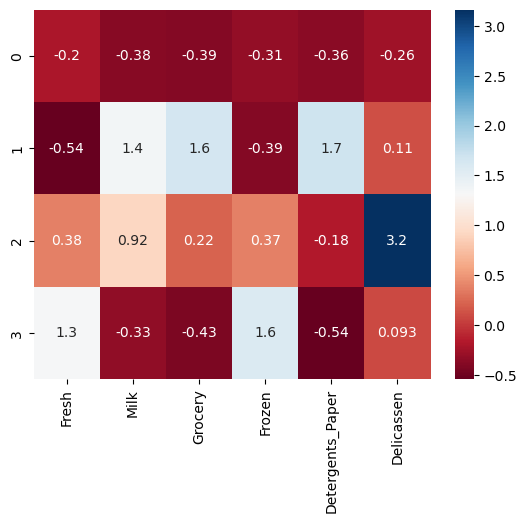

In [231]:
# Create a heat map of the cluster centers
import seaborn as sns

cluster_centers4 = pd.DataFrame(kmeans4.cluster_centers_, columns=data_scaled.columns)
sns.heatmap(cluster_centers4, cmap='RdBu', annot=True);

In [232]:
# Name the clusters


- Cluster 0 (Low Spend Group):
Characteristics: This cluster generally shows low spending across all categories, with no particularly strong emphasis on any single product category.
Suggested Name: "Minimal Spenders" or "Low Volume Shoppers"

- Cluster 1 (Diverse High Spend Group):
Characteristics: This group spends heavily across several categories, particularly on 'Milk', 'Grocery', and 'Detergents_Paper'. They also show significant spending in 'Delicassen'.
Suggested Name: "Broad Range High Spenders" or "Versatile Big Spenders"

- Cluster 2 (Selective High Spend Group):
Characteristics: Members of this cluster show notably high expenditure specifically in the 'Delicassen' category, with moderate to low spending in other areas.
Suggested Name: "Delicatessen Enthusiasts" or "Specialty Goods Shoppers"

- Cluster 3 (Fresh and Frozen Focus Group):
Characteristics: This cluster has high spending in 'Fresh' and 'Frozen' categories, indicating a preference for perishable and frozen goods, possibly suggesting a focus on quality or freshness.
Suggested Name: "Fresh and Frozen Food Lovers" or "Perishable Goods Preferers"

- Cluster 0: "Basic Buyers"
- Cluster 1: "Super Shoppers"
- Cluster 2: "Gourmet Gurus"
- Cluster 3: "Fresh Favorites"

In [242]:
data['cluster_Number']=kmeans4.labels_
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster_Number
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,3
4,22615,5410,7198,3915,1777,5185,2


In [244]:
final_data = df.merge(data,how='left')

In [246]:
final_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster,cluster_Number
0,2,3,12669,9656,7561,214,2674,1338,0,0.0
1,2,3,7057,9810,9568,1762,3293,1776,0,0.0
2,2,3,6353,8808,7684,2405,3516,7844,0,2.0
3,1,3,13265,1196,4221,6404,507,1788,0,3.0
4,2,3,22615,5410,7198,3915,1777,5185,0,2.0


In [276]:
# our dataset is correct, because cluster_number has 10 Nan values equivalent to the outliers that we already subtracted.
final_data.isna().sum()

Channel              0
Region               0
Fresh                0
Milk                 0
Grocery              0
Frozen               0
Detergents_Paper     0
Delicassen           0
DBSCAN_cluster       0
cluster_Number      10
dtype: int64

In [248]:
final_data[final_data['DBSCAN_cluster']==0]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,DBSCAN_cluster,cluster_Number
0,2,3,12669,9656,7561,214,2674,1338,0,0.0
1,2,3,7057,9810,9568,1762,3293,1776,0,0.0
2,2,3,6353,8808,7684,2405,3516,7844,0,2.0
3,1,3,13265,1196,4221,6404,507,1788,0,3.0
4,2,3,22615,5410,7198,3915,1777,5185,0,2.0
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,0,3.0
436,1,3,39228,1431,764,4510,93,2346,0,3.0
437,2,3,14531,15488,30243,437,14841,1867,0,1.0
438,1,3,10290,1981,2232,1038,168,2125,0,0.0


## 4. PCA for visualization

In [252]:
data_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.103978,0.896020,0.043570,-0.777226,0.026766,-0.001121
1,-0.383280,0.926465,0.319942,-0.303520,0.193609,0.285739
2,-0.444404,0.728374,0.060508,-0.106755,0.253716,4.259858
3,0.155726,-0.776483,-0.416361,1.116985,-0.557319,0.293598
4,0.967533,0.056605,-0.006416,0.355323,-0.215008,2.518397


In [256]:
# fit a PCA model with 2 components, we fit with data_scaled (Already standardize)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(data_scaled)

PCA(n_components=2)

In [258]:
# view the explained variance ratio
pca.explained_variance_ratio_

array([0.45561095, 0.24801985])

In [260]:
# view the components
pca.components_

array([[-0.17874769,  0.52464326,  0.57063668, -0.14651492,  0.56095866,
         0.17615689],
       [ 0.58855447,  0.1473215 ,  0.06828439,  0.58196421, -0.03601239,
         0.53596457]])

In [264]:
# view the columns
data_scaled.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

Interpret the components:


- Component 1: Higher spending on non-perishables (Milk, Grocery, Detergents).
- Component 2: Higher spending on perishables (Fresh, Frozen).

### b. Overlay the K-Means cluster colors


In [270]:
# transform the data
df_scaled_transformed = pd.DataFrame(pca.transform(data_scaled), columns=['PC1', 'PC2'])
df_scaled_transformed.head()

,PC1,PC2
0,0.605060,-0.257707
1,0.940556,-0.097710
2,1.404469,2.061750
3,-1.097371,0.776303
4,0.124054,2.141646


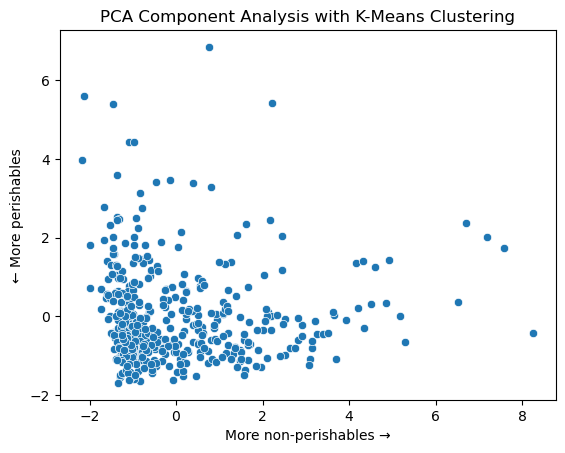

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the data with updated labels
sns.scatterplot(x='PC1', y='PC2', data=df_scaled_transformed)
plt.xlabel('More non-perishables →')
plt.ylabel('← More perishables')
plt.title('PCA Component Analysis with K-Means Clustering')
plt.show()


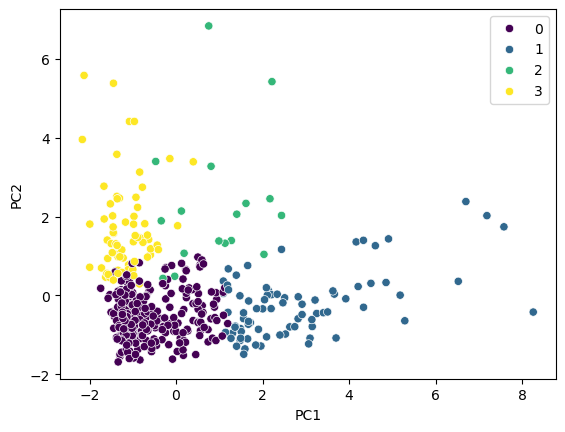

In [274]:
# overlay the kmeans clusters (hint: set the hue to be the cluster labels)
sns.scatterplot(x='PC1',
                y='PC2',
                data=df_scaled_transformed, hue=kmeans4.labels_, palette='viridis');